In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder,StandardScaler,MinMaxScaler,LabelEncoder,OrdinalEncoder
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [164]:
df = pd.read_excel('../data/premiums_with_life_style.xlsx')
df.head()

,Age,Gender,Region,Marital_status,Physical_Activity,Stress_Level,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459
3,55,Male,Northeast,Married,High,Medium,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685
4,22,Male,Southeast,Unmarried,Medium,High,2,Normal,Regular,Self-Employed,10L - 25L,13,High blood pressure & Heart disease,Bronze,15984


In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    10000 non-null  int64 
 1   Gender                 10000 non-null  object
 2   Region                 10000 non-null  object
 3   Marital_status         10000 non-null  object
 4   Physical_Activity      10000 non-null  object
 5   Stress_Level           10000 non-null  object
 6   Number Of Dependants   10000 non-null  int64 
 7   BMI_Category           10000 non-null  object
 8   Smoking_Status         9991 non-null   object
 9   Employment_Status      9993 non-null   object
 10  Income_Level           9982 non-null   object
 11  Income_Lakhs           10000 non-null  int64 
 12  Medical History        10000 non-null  object
 13  Insurance_Plan         10000 non-null  object
 14  Annual_Premium_Amount  10000 non-null  int64 
dtypes: int64(4), object(

In [166]:
print(f'Number of rows - {df.shape[0]}\nNumber of cols - {df.shape[1]}')

Number of rows - 10000
Number of cols - 15


In [167]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Physical_Activity',
       'Stress_Level', 'Number Of Dependants', 'BMI_Category',
       'Smoking_Status', 'Employment_Status', 'Income_Level', 'Income_Lakhs',
       'Medical History', 'Insurance_Plan', 'Annual_Premium_Amount'],
      dtype='object')

## Notes - 
- The Name of the cols are not constand so let's fix it

In [168]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'physical_activity',
       'stress_level', 'number_of_dependants', 'bmi_category',
       'smoking_status', 'employment_status', 'income_level', 'income_lakhs',
       'medical_history', 'insurance_plan', 'annual_premium_amount'],
      dtype='object')

## Missing Values Identification/Tretments

In [169]:
# Let's look for Missing values in our data

df.isnull().sum()

age                       0
gender                    0
region                    0
marital_status            0
physical_activity         0
stress_level              0
number_of_dependants      0
bmi_category              0
smoking_status            9
employment_status         7
income_level             18
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [170]:

# Let's check the percentage of Missing values on the respective cols -

print('Missing Values in Percentag - ')
Employment_Status = round((df['employment_status'].isnull().sum()/df.shape[0])*100,2)
Smoking_Status = round((df['smoking_status'].isnull().sum()/df.shape[0])*100,2)
Income_Level = round((df['income_level'].isnull().sum()/df.shape[0])*100,2)

print(f'Employment Status it is - {Employment_Status}\nSmoking Status it is = {Smoking_Status}\nIncome Level it is - {Income_Level}')

Missing Values in Percentag - 
Employment Status it is - 0.07
Smoking Status it is = 0.09
Income Level it is - 0.18


## Note -
- As we can notice that the missing precentage is less then `1%` so we can remove those records

In [171]:
# Remove Missing Values recorde -
df.dropna(inplace=True)
print(f'Number of rows - {df.shape[0]}\nNumber of cols - {df.shape[1]}')

Number of rows - 9973
Number of cols - 15


## Let first look into numirical features

In [172]:
num_feature = df.select_dtypes(exclude='object').columns
num_feature

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

In [173]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,9973.000000,9973.000000,9973.000000,9973.000000
mean,41.319362,3.195628,23.382232,19503.816705
std,58.044687,21.679565,32.334811,8898.079736
min,18.000000,0.000000,1.000000,3582.000000
25%,24.000000,0.000000,6.000000,11774.000000
50%,37.000000,2.000000,16.000000,19314.000000
75%,50.000000,3.000000,31.000000,26500.000000
max,1178.000000,456.000000,960.000000,45854.000000


## Notes -
- As we can see that in `Age` the max is `1178` which is not possibel it can be a outlier or manuale error
- Same for `Number of Dependents` the max is `456` which is not likely senario for any one to have 456 dependants 

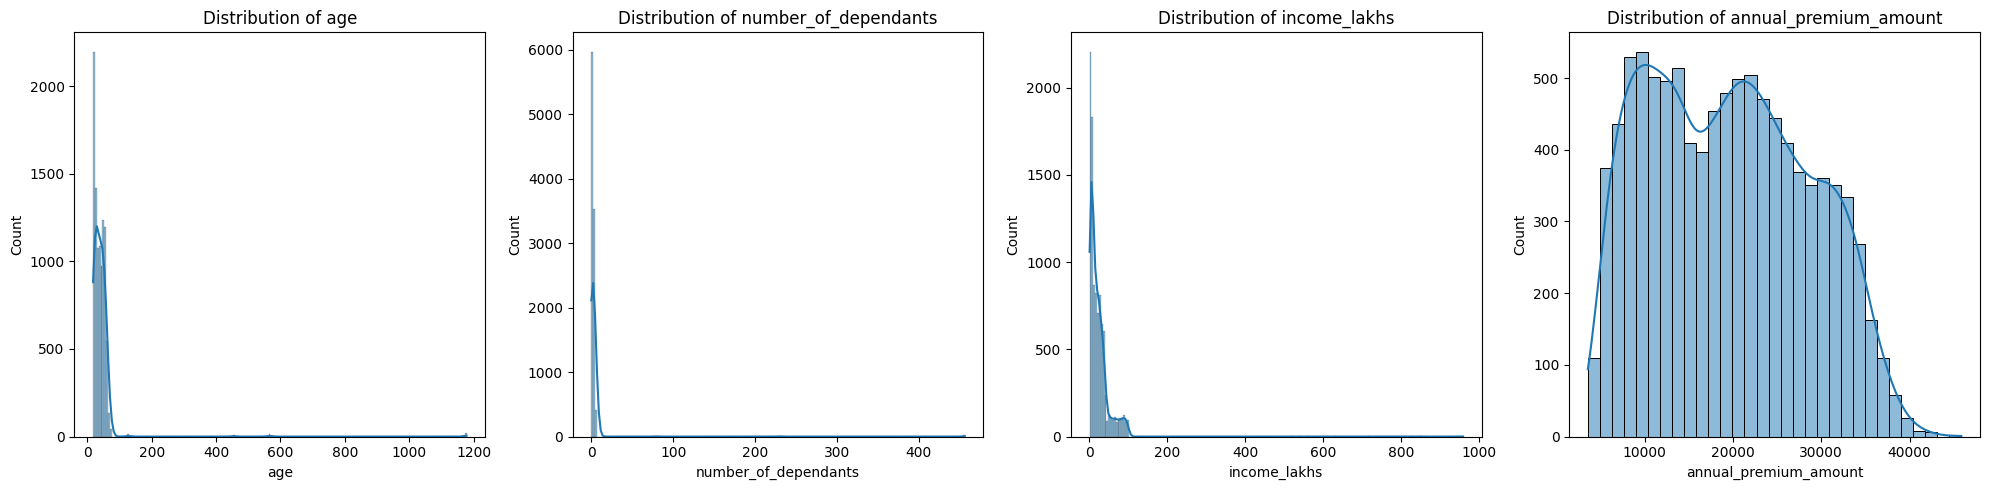

In [174]:
# Look into the histograms of all the numirical feature -

# Number of numeric features
n = len(num_feature)

# Create subplots with 1 row and n columns
fig, axes = plt.subplots(1, n, figsize=(5*n, 5))  # width expands with number of plots

# Loop through features and axes together
for ax, col in zip(axes, num_feature):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

## Notes -
- looking like for `Income_Lakhs` feature we have outliers also

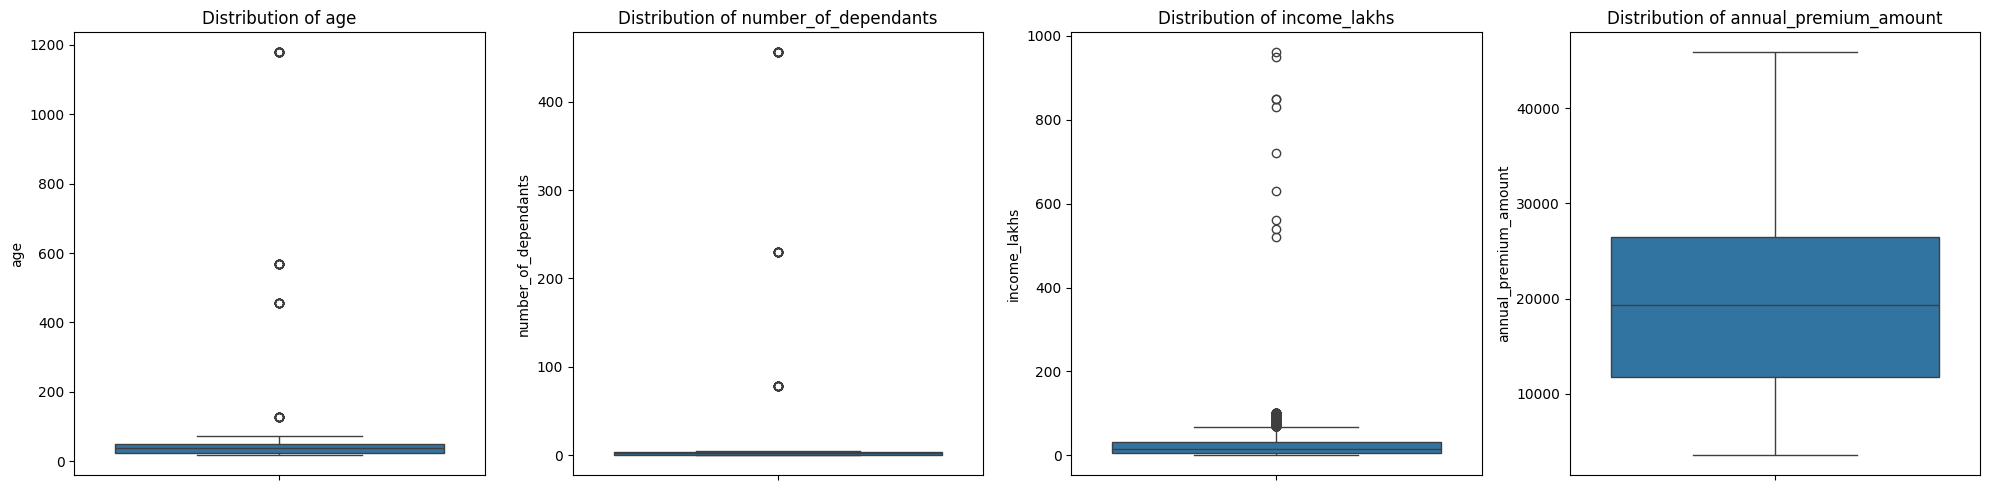

In [175]:
# Let's create box plot -

# Number of numeric features
n = len(num_feature)

# Create subplots with 1 row and n columns
fig, axes = plt.subplots(1, n, figsize=(5*n, 5))  # width expands with number of plots

# Loop through features and axes together
for ax, col in zip(axes, num_feature):
    sns.boxplot(df[col], ax=ax)
    ax.set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

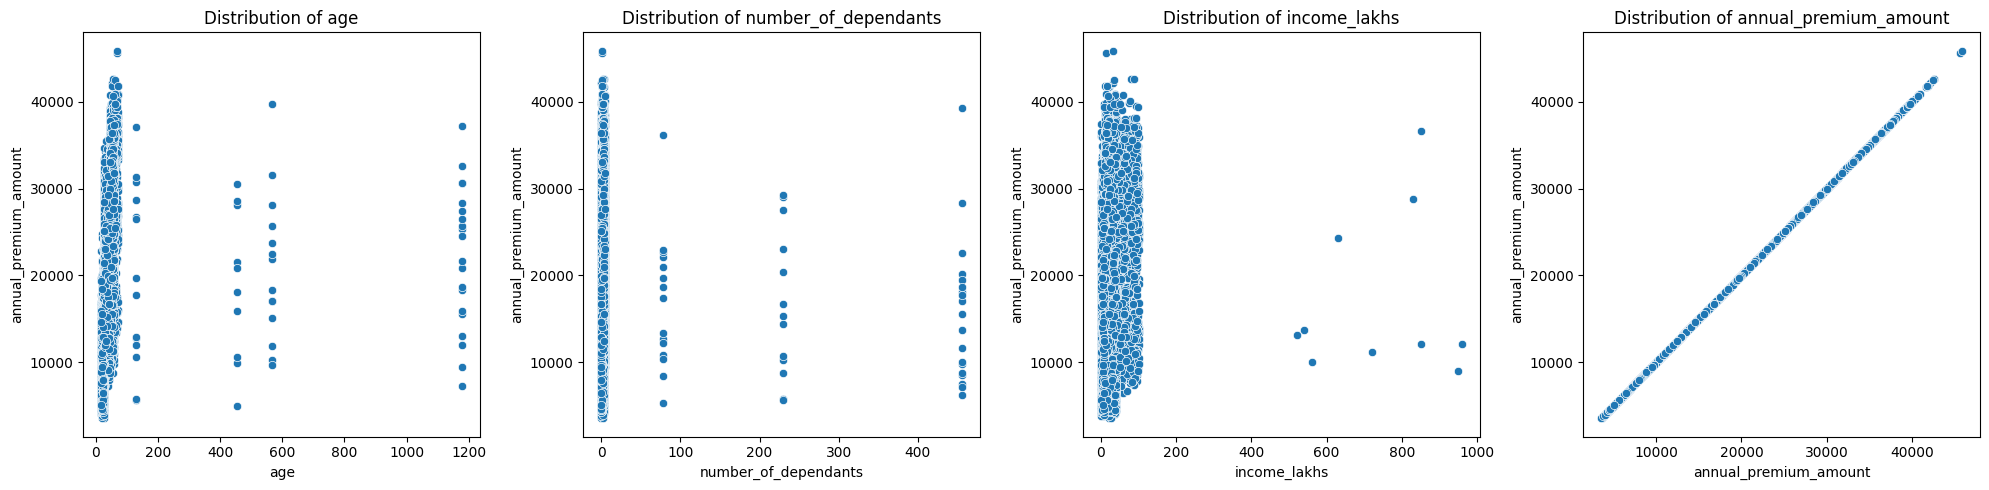

In [176]:
# Scatter plot
# Number of numeric features
n = len(num_feature)

# Create subplots with 1 row and n columns
fig, axes = plt.subplots(1, n, figsize=(5*n, 5))  # width expands with number of plots

# Loop through features and axes together
for ax, col in zip(axes, num_feature):
    sns.scatterplot(df,x=col,y='annual_premium_amount', ax=ax)
    ax.set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

## Age - Feature

In [177]:
# lets look into Age
# As we know Age can't be more then 100 (For Normal senario)

df[df['age']>100]

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
79,128,Female,Northwest,Married,Low,High,3,Obesity,Occasional,Self-Employed,25L - 40L,38,Heart disease,Silver,30696
129,128,Male,Southeast,Married,Low,High,3,Obesity,Regular,Self-Employed,10L - 25L,12,No Disease,Gold,37061
170,1178,Male,Southwest,Unmarried,Medium,Medium,0,Normal,Regular,Salaried,<10L,5,Heart disease,Silver,18349
533,567,Male,Southeast,Married,Medium,Medium,2,Normal,Regular,Self-Employed,> 40L,43,High blood pressure,Gold,31545
652,456,Female,Southeast,Unmarried,Medium,Low,1,Normal,No Smoking,Salaried,> 40L,52,Diabetes & Thyroid,Gold,15927
767,1178,Female,Southeast,Unmarried,Medium,High,0,Obesity,No Smoking,Self-Employed,25L - 40L,39,Heart disease,Gold,37181
826,456,Female,Southwest,Unmarried,Low,Medium,2,Obesity,No Smoking,Self-Employed,<10L,2,Diabetes & High blood pressure,Silver,28086
1426,1178,Female,Northwest,Unmarried,Medium,Medium,0,Normal,Regular,Self-Employed,25L - 40L,31,No Disease,Silver,13094
1554,1178,Male,Southwest,Unmarried,High,Low,0,Normal,No Smoking,Freelancer,25L - 40L,39,Diabetes,Silver,9423
1997,128,Male,Southwest,Unmarried,Low,Medium,0,Obesity,No Smoking,Salaried,<10L,5,Thyroid,Bronze,17713


In [178]:
# Let see the unique values more then 100 for age
df[df['age']>100]['age'].unique()

array([ 128, 1178,  567,  456])

In [179]:
# Let check the number of rows have age more then 100
df[df['age']>100].shape

(58, 15)

## Notes -
- As we can notice that there are `58` recordes where the age is more then 100
- The for those `58` recordes we have ages for `[ 128, 1178,  567,  456]`
- As we don't know the actuale values for those `58` recored we can `drop` those or `filter out` thoese records

In [180]:
df1 = df[df['age']<=100].copy()
df1.head()

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459
3,55,Male,Northeast,Married,High,Medium,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685
4,22,Male,Southeast,Unmarried,Medium,High,2,Normal,Regular,Self-Employed,10L - 25L,13,High blood pressure & Heart disease,Bronze,15984


In [181]:
print(f'Number of rows - {df1.shape[0]}\nNumber of cols - {df1.shape[1]}')

Number of rows - 9915
Number of cols - 15


## Number of Dependants - Feature

In [182]:
# Let look into `Number of Dependent`
# Let's use IQR to ideintify upper and lower bounds

def get_outlier(df,col,qu1 = 0.25,qu2 = 0.75):
    q1,q3 = df[col].quantile([qu1,qu2])
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    return lower_bound,upper_bound

lower_bound,upper_bound = get_outlier(df1,'number_of_dependants')

print(f'Lower bound for Number of Dependent feature - {lower_bound}\nUpper bound for Number of Dependent feature - {upper_bound}')

Lower bound for Number of Dependent feature - -4.5
Upper bound for Number of Dependent feature - 7.5


In [183]:
# Let see the total number of recordes more the the upper bound
df1[df1['number_of_dependants']>=upper_bound]
df1[df1['number_of_dependants']>=upper_bound].shape

(47, 15)

In [184]:
# Let see the unique values more then the upper bound for Number of Dependance
df1[df1['number_of_dependants']>=upper_bound]['number_of_dependants'].unique()

array([456,  78, 230])

## Notes -
- As we notice the total number of recordes for `Number Of Dependants` more then upper bound `(7.5)` is `47` recordes.
- Those `47` recordes are distributred with `[456,  78, 230]`.
- So, we can remove those recordes

In [185]:
df1 = df1[df1['number_of_dependants']<=upper_bound]
df1.head()

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459
3,55,Male,Northeast,Married,High,Medium,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685
4,22,Male,Southeast,Unmarried,Medium,High,2,Normal,Regular,Self-Employed,10L - 25L,13,High blood pressure & Heart disease,Bronze,15984


In [186]:
print(f'Number of rows - {df1.shape[0]}\nNumber of cols - {df1.shape[1]}')

Number of rows - 9868
Number of cols - 15


In [187]:
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,9868.000000,9868.000000,9868.000000,9868.000000
mean,37.756486,1.919133,23.411634,19511.417714
std,13.976822,1.503264,32.437621,8900.941540
min,18.000000,0.000000,1.000000,3582.000000
25%,24.000000,0.000000,6.000000,11776.250000
50%,37.000000,2.000000,16.000000,19327.500000
75%,50.000000,3.000000,31.000000,26505.250000
max,72.000000,5.000000,960.000000,45854.000000


## Income Lakhs - Feature

In [188]:
# Let look into 'income Lakhs`
# apply iqr

lower_bound,upper_bound = get_outlier(df1,'income_lakhs')
print(f'Lower bound for Number of Dependent feature - {lower_bound}\nUpper bound for Number of Dependent feature - {upper_bound}')

Lower bound for Number of Dependent feature - -31.5
Upper bound for Number of Dependent feature - 68.5


In [189]:
q1 = 0.25
q3 = 0.95
lower_bound,upper_bound = get_outlier(df1,'income_lakhs',q1,q3)
print(f'Lower bound for Number of Dependent feature - {lower_bound}\nUpper bound for Number of Dependent feature - {upper_bound}')

Lower bound for Number of Dependent feature - -102.0
Upper bound for Number of Dependent feature - 186.0


In [190]:
# Look into the number of recordes in the upper bound
df1[df1['income_lakhs']>=upper_bound].shape

(10, 15)

In [191]:
# What are the unique values
df1[df1['income_lakhs']>=upper_bound]['income_lakhs'].unique()

array([850, 950, 830, 560, 540, 720, 520, 630, 960])

## Notes - 
- By Default the quantile 1 value is `25%` and quantile 3 value is `75%`.
- When we apply default quatile values the upper bound is `68.5` which is very less as per our distribution plot.
- Majority are under around 100.
- After tuking the quantile 1 value is `25%` and quantile 3 value is `95%` the upper bound is `186.5`.
- As it is only 10 records have more then upper bound, So we filter out those.

In [192]:
df1 = df1[df1['income_lakhs']<upper_bound]
print(f'Number of rows - {df1.shape[0]}\nNumber of cols - {df1.shape[1]}')

Number of rows - 9858
Number of cols - 15


## Now Looks into Categorical Features

In [193]:
cat_features = df1.select_dtypes(include='object').columns
cat_features

Index(['gender', 'region', 'marital_status', 'physical_activity',
       'stress_level', 'bmi_category', 'smoking_status', 'employment_status',
       'income_level', 'medical_history', 'insurance_plan'],
      dtype='object')

In [194]:
# Let's look it the unique values of those categorical features

for i in cat_features:
    print(f'{i} has  - {df1[i].unique()} unique values')

gender has  - ['Female' 'Male'] unique values
region has  - ['Southeast' 'Northeast' 'Southwest' 'Northwest'] unique values
marital_status has  - ['Unmarried' 'Married'] unique values
physical_activity has  - ['Medium' 'Low' 'High'] unique values
stress_level has  - ['Medium' 'High' 'Low'] unique values
bmi_category has  - ['Normal' 'Overweight' 'Obesity' 'Underweight'] unique values
smoking_status has  - ['No Smoking' 'Occasional' 'Regular'] unique values
employment_status has  - ['Self-Employed' 'Freelancer' 'Salaried'] unique values
income_level has  - ['25L - 40L' '10L - 25L' '<10L' '> 40L'] unique values
medical_history has  - ['High blood pressure' 'No Disease' 'Thyroid'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid' 'Diabetes'
 'Heart disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease'] unique values
insurance_plan has  - ['Gold' 'Silver' 'Bronze'] unique values


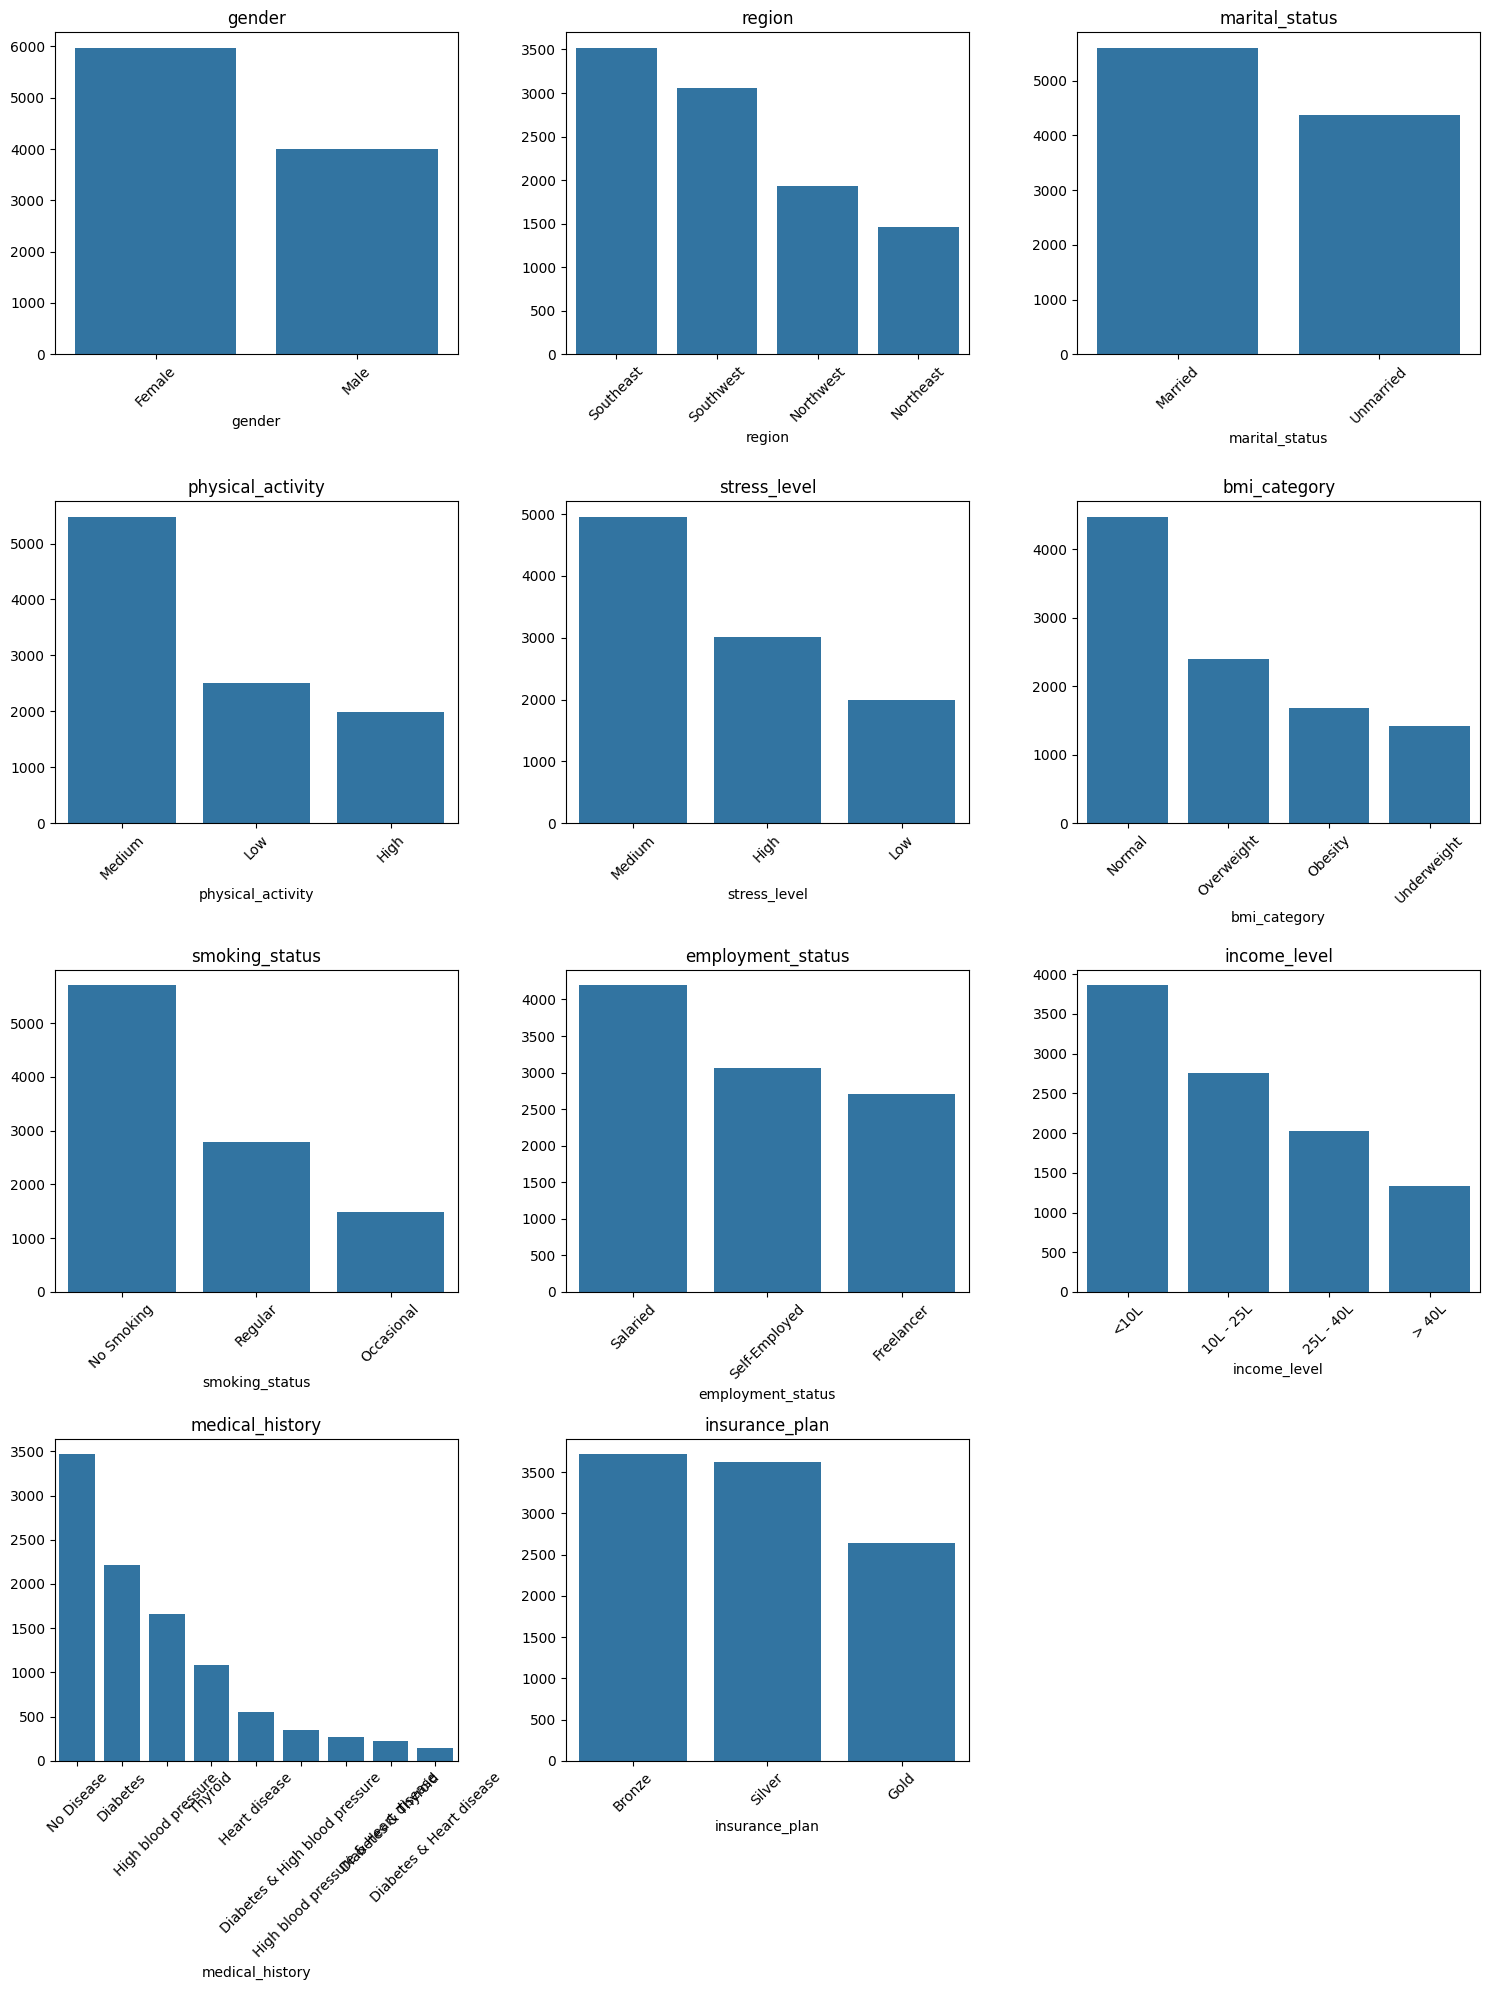

In [195]:
# Bar plot for categorical feature

# number of categorical features
n_features = len(cat_features)

# define grid size
rows = (n_features // 3) + 1
cols = 3

plt.figure(figsize=(15, rows*5))  # adjust size

for idx, col in enumerate(cat_features, 1):
    plt.subplot(rows, cols, idx)
    sns.barplot(x=df[col].value_counts().index, 
                y=df[col].value_counts().values)
    plt.title(col)
    plt.xticks(rotation=45)  # rotate labels for readability

plt.tight_layout()
plt.show()

In [196]:
cat_features

Index(['gender', 'region', 'marital_status', 'physical_activity',
       'stress_level', 'bmi_category', 'smoking_status', 'employment_status',
       'income_level', 'medical_history', 'insurance_plan'],
      dtype='object')

In [197]:
# Let create cross tab between all catgorical features with insurance plan

tab = pd.crosstab(index=df1['insurance_plan'],columns=df1['stress_level'],normalize=True)
tab

stress_level,High,Low,Medium
insurance_plan,,,
Bronze,0.111077,0.075167,0.186650
Gold,0.084500,0.050822,0.129844
Silver,0.107121,0.073240,0.181578


<Axes: xlabel='insurance_plan'>

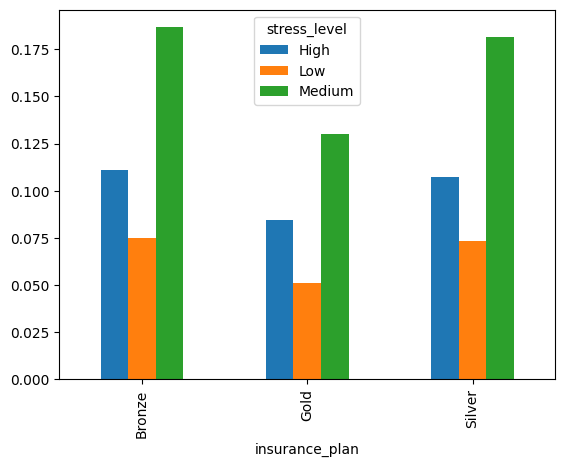

In [198]:
tab.plot(kind='bar')

<Axes: xlabel='stress_level', ylabel='insurance_plan'>

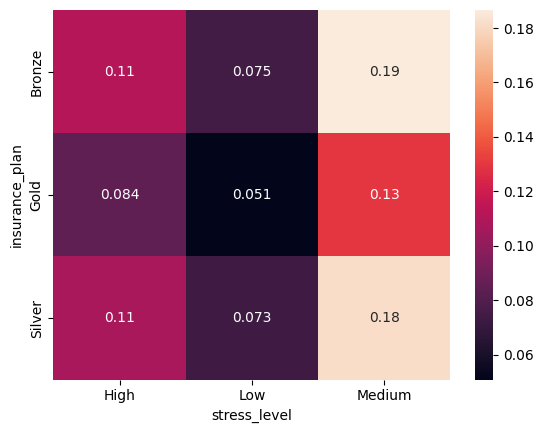

In [199]:
sns.heatmap(tab,annot=True)

## Medical History -  Feature

In [200]:
# Let split `medical history` feature into two cols

df1[['disease1','disease2']]  = df1['medical_history'].str.split(' & ',expand=True).apply(lambda x: x.str.lower())

In [201]:
# as per business we have a risk score

risk_score ={
    'diabetes':6,
    'heart disease':8,
    'high blood pressure':6,
    'thyroid':5,
    'no disease':0,
    'none':0
}

In [202]:
df1['disease1'].fillna('none',inplace=True)
df1['disease2'].fillna('none',inplace=True)

In [203]:
# Create a new col total_risk_score

df1['total_risk_score'] = 0

for i in df1[['disease1','disease2']]:
    df1['total_risk_score'] += df1[i].map(risk_score)

In [204]:
df1.head()

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944,high blood pressure,none,6
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108,no disease,none,0
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459,no disease,none,0
3,55,Male,Northeast,Married,High,Medium,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685,thyroid,none,5
4,22,Male,Southeast,Unmarried,Medium,High,2,Normal,Regular,Self-Employed,10L - 25L,13,High blood pressure & Heart disease,Bronze,15984,high blood pressure,heart disease,14


## Notes -
- As we have created a new col `total_risk_score` for the feature `medical_history` 
- So now we can drop `[medical_history,disease1,disease2]` from the table

In [205]:
df1.drop(columns=['medical_history','disease1','disease2'],axis=1,inplace=True)
df1.head()

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,Gold,27944,6
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,Silver,21108,0
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,Bronze,8459,0
3,55,Male,Northeast,Married,High,Medium,3,Overweight,Occasional,Salaried,<10L,9,Silver,21685,5
4,22,Male,Southeast,Unmarried,Medium,High,2,Normal,Regular,Self-Employed,10L - 25L,13,Bronze,15984,14


## Physical Activity and Stress Level - Feature

In [206]:
# also as per bussiness physical_activity and stress_level can be combined
# map the values provide by bussiness to thoes features

print(df1['physical_activity'].unique())
print(df1['stress_level'].unique())

['Medium' 'Low' 'High']
['Medium' 'High' 'Low']


In [207]:
# Physical_Activity: High = 0, Medium = 1, Low = 4

df1['physical_activity'] = df1['physical_activity'].map({'High':0,'Medium':1,'Low':4})

# Stress_Level: High = 4, Medium = 1, Low = 0

df1['stress_level'] = df1['stress_level'].map({'High':4,'Medium':1,'Low':0})

# Create new col life_style_risk_score

df1['life_style_risk_score'] = df1['physical_activity'] + df1['stress_level']

df1[['physical_activity','stress_level','life_style_risk_score']]


,physical_activity,stress_level,life_style_risk_score
0,1,1,2
1,4,4,8
2,1,4,5
3,0,1,1
4,1,4,5
...,...,...,...
9995,1,1,2
9996,0,1,1
9997,1,4,5
9998,0,0,0


## Notes - 
- As per the buisness the features `physical_activity` and `stress_level` should be convated to the respective values -
    - Physical_Activity: High = 0, Medium = 1, Low = 4.
    - Stress_Level: High = 4, Medium = 1, Low = 0.
- Using those create a new feature `life_style_risk_score` -
    - `life_style_risk_score` = `physical_activity` + `stress_level`.
- As now we have created a new feature we can drop the redandant features `physical_activity` and `stress_level`

In [208]:
df1.drop(columns=['physical_activity', 'stress_level'],axis=1,inplace=True)
print(f'Number of rows - {df1.shape[0]}\nNumber of cols - {df1.shape[1]}')

Number of rows - 9858
Number of cols - 14


In [209]:
df1.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score,life_style_risk_score
0,56,Female,Southeast,Unmarried,2,Normal,No Smoking,Self-Employed,25L - 40L,37,Gold,27944,6,2
1,38,Female,Northeast,Married,5,Overweight,Occasional,Freelancer,10L - 25L,10,Silver,21108,0,8
2,18,Female,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,<10L,9,Bronze,8459,0,5
3,55,Male,Northeast,Married,3,Overweight,Occasional,Salaried,<10L,9,Silver,21685,5,1
4,22,Male,Southeast,Unmarried,2,Normal,Regular,Self-Employed,10L - 25L,13,Bronze,15984,14,5


In [210]:
# Lets look into VIF -
# To find multicolinarity -

num_features = df1.select_dtypes(exclude='object').drop('annual_premium_amount',axis=1).columns
cat_features = df1.select_dtypes(include='object').columns

print(f'All the numirical features {num_features} Length {len(num_features)}')
print(f'All the categorical features {cat_features} Length {len(cat_features)}')

All the numirical features Index(['age', 'number_of_dependants', 'income_lakhs', 'total_risk_score',
       'life_style_risk_score'],
      dtype='object') Length 5
All the categorical features Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'insurance_plan'],
      dtype='object') Length 8


In [211]:
num_nominal_feature = ['age', 'number_of_dependants', 'income_lakhs'] # StandardScale
num_odinal_feature = ['total_risk_score','life_style_risk_score'] # MinmaxScale
cat_nominal_feature = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status','employment_status'] # Onehotencoder
cat_odinal_feature = ['income_level', 'insurance_plan'] # Odinalencoder

## Notes - 
- Identify which are `Numerical Features` and which are `Categorical Features`.
- Remove the target feature `annual_premium_amount`.

In [212]:
x = df1.drop('annual_premium_amount',axis=1)
y = df1['annual_premium_amount']

cat_odinal_feature_pip = Pipeline([
    ('OrdinalEncoder',OrdinalEncoder()),
    ('scaler',MinMaxScaler())
])

transf = ColumnTransformer(
    [
        ('standardscaler',StandardScaler(),num_nominal_feature),
        ('minmaxscaler',MinMaxScaler(),num_odinal_feature),
        ('onehotencoder',OneHotEncoder(drop='first'),cat_nominal_feature),
        ('encoder',cat_odinal_feature_pip,cat_odinal_feature)
    ]
)

transf

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['age', 'number_of_dependants',
                                  'income_lakhs']),
                                ('minmaxscaler', MinMaxScaler(),
                                 ['total_risk_score', 'life_style_risk_score']),
                                ('onehotencoder', OneHotEncoder(drop='first'),
                                 ['gender', 'region', 'marital_status',
                                  'bmi_category', 'smoking_status',
                                  'employment_status']),
                                ('encoder',
                                 Pipeline(steps=[('OrdinalEncoder',
                                                  OrdinalEncoder()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['income_level', 'insurance_plan'])])

In [213]:
x_transf = transf.fit_transform(x)

In [214]:
ohe_feature = transf.named_transformers_['onehotencoder'].get_feature_names_out(cat_nominal_feature)
all_feature = num_nominal_feature+num_odinal_feature+list(ohe_feature)+cat_odinal_feature

In [215]:
df_transfor = pd.DataFrame(x_transf,columns=all_feature,index=x.index)
df_transfor

,age,number_of_dependants,income_lakhs,total_risk_score,life_style_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed,income_level,insurance_plan
0,1.304795,0.053253,0.637636,0.428571,0.250,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.333333,0.5
1,0.016832,2.049326,-0.564922,0.000000,1.000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.000000,1.0
2,-1.414238,-1.277463,-0.609461,0.000000,0.625,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0
3,1.233242,0.718611,-0.609461,0.357143,0.125,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.666667,1.0
4,-1.128024,0.053253,-0.431304,1.000000,0.625,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.484042,2.049326,-0.431304,0.428571,0.250,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,1.0
9996,-0.984917,-1.277463,0.281322,0.428571,0.125,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.0
9997,-1.414238,-1.277463,-0.743079,0.000000,0.625,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.666667,1.0
9998,-0.698703,-1.277463,0.192244,0.428571,0.000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.333333,0.5


In [216]:
def cal_vif(data):
    vif_df = pd.DataFrame()
    vif_df['col'] = data.columns
    vif_df['vif'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [217]:
cal_vif(df_transfor)

,col,vif
0,age,1.683046
1,number_of_dependants,3.119728
2,income_lakhs,1.156835
3,total_risk_score,2.858240
4,life_style_risk_score,3.001664
5,gender_Male,1.894797
6,region_Northwest,1.952003
7,region_Southeast,2.674946
8,region_Southwest,2.477134
9,marital_status_Unmarried,5.760329


## Notes - 
- I have scale the data -
    - num_nominal_feature = `['age', 'number_of_dependants', 'income_lakhs']` # StandardScale
    - num_odinal_feature = `['total_risk_score','life_style_risk_score']` # MinmaxScale
- I have encoder the data - 
    - cat_nominal_feature = `['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status','employment_status']` # Onehotencoder
    - cat_odinal_feature = `['income_level', 'insurance_plan']` # Odinalencoder
- The we have calculated the VIF for all the cols and find out that there is no issue of multicolinarity because all values are less then `5`

## Train Test Split

In [218]:
x_train,x_test,y_train,y_test = train_test_split(df_transfor,y,test_size=0.2,random_state=42)

## Model Traning - 

In [219]:
model_params = {
    'LinearRegression':{
        'model':LinearRegression(),
        'params':{}
    },
    'Ridge':{
        'model':Ridge(),
        'params':{}
    },
    'Lasso':{
        'model':Lasso(),
        'params':{}
    },
    'DecisionTreeRegressor':{
        'model':DecisionTreeRegressor(),
        'params':{
            'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
            'max_depth':[5,10,15,20]
        }
    },
    'RandomForestRegressor':{
        'model':RandomForestRegressor(),
        'params':{
            'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
            'max_depth':[5,10,15,20]
        }
    },
    'XGBRegressor':{
        'model':XGBRegressor(),
        'params':{
            'n_estimators':[20,40,50],
            'learning_rate':[0.01,0.1,0.2],
            'max_depth':[3,4,5]
        }
    }
}

score = []

for key,val in model_params.items():
    randomcv = RandomizedSearchCV(
        val['model'],
        val['params'],
        return_train_score=True,
        cv=5,
        n_iter=10,
        n_jobs=-1
    )
    randomcv.fit(x_train,y_train)
    score.append({
        'model':key,
        'best_params':randomcv.best_params_,
        'best_score_test':round(randomcv.best_score_*100,2),
        'best_scroe_train':round(randomcv.cv_results_['mean_train_score'][randomcv.best_index_]*100,2)
    })

pd.DataFrame(score)

,model,best_params,best_score_test,best_scroe_train
0,LinearRegression,{},79.14,79.27
1,Ridge,{},79.14,79.27
2,Lasso,{},79.14,79.27
3,DecisionTreeRegressor,"{'max_depth': 15, 'criterion': 'squared_error'}",98.39,99.90
4,RandomForestRegressor,"{'max_depth': 15, 'criterion': 'friedman_mse'}",99.03,99.81
5,XGBRegressor,"{'n_estimators': 50, 'max_depth': 3, 'learning...",99.31,99.37


## Notes-
- After Hypertraning below are the score - 
    - for `DecisionTreeRegressor` with `{'max_depth': 15, 'criterion': 'friedman_mse'}` the test score is `98.35%` and the training score is `99.15%`.
    - for `RandomForestRegressor` with `{'max_depth': 15, 'criterion': 'friedman_mse'}` the test score is `99.03%` and the training score is `99.81%`.
    - for `XGBRegressor` with `{'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.2}` the test score is `99.44%` and the training score is `99.58%`.

- There is no `overfitting` issue

In [220]:
# Lets take the best model which is XGBRegressor

model = XGBRegressor(
    n_estimators = 50, 
    max_depth = 4, 
    learning_rate = 0.2
)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

r2 = r2_score(y_pred,y_test)
mse = mean_squared_error(y_pred,y_test)
mae = mean_absolute_error(y_pred,y_test)

print(f'The R2 value is {round(r2*100,2)}\nThe Mean Squared Error value is {mse}\nThe Mean Absolute Error value is {mae}')

The R2 value is 99.41
The Mean Squared Error value is 453611.03125
The Mean Absolute Error value is 558.1627807617188


<Axes: xlabel='coefficents', ylabel='None'>

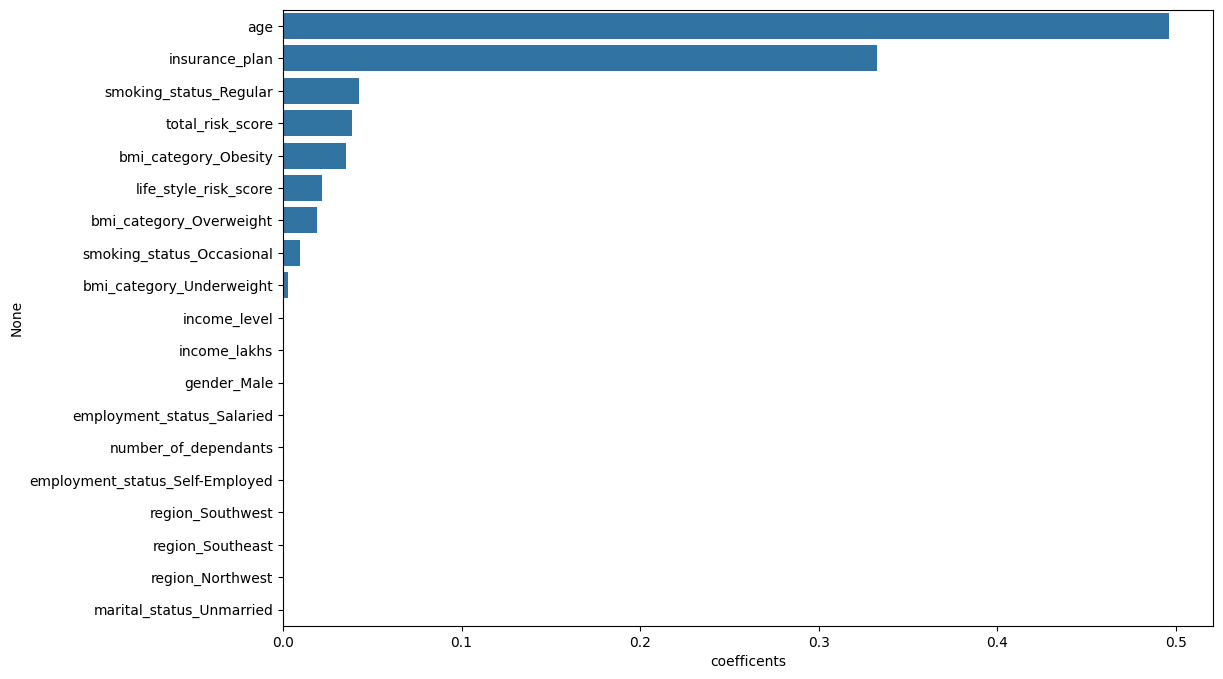

In [221]:
feature_imp = model.feature_importances_
cof_df = pd.DataFrame(feature_imp,index=x_test.columns,columns=['coefficents'])
cof_df = cof_df.sort_values(by='coefficents',ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(cof_df,x='coefficents',y=cof_df.index)

# Notes -
- The most importent features are `age` and `insurance plan`

## Error Analysis

In [222]:
diff = y_pred - y_test
diff_pct = diff*100/y_test

result_df = pd.DataFrame({
    'actual':y_test,
    'predict':y_pred,
    'residuals':diff,
    'residual_pct':diff_pct
})

result_df

,actual,predict,residuals,residual_pct
8496,30733,30459.222656,-273.777344,-0.890825
507,32997,32739.578125,-257.421875,-0.780137
5147,15251,16418.771484,1167.771484,7.657016
887,6936,7651.157715,715.157715,10.310809
8848,10909,11616.929688,707.929688,6.489410
...,...,...,...,...
7231,32742,31661.710938,-1080.289062,-3.299399
6771,31845,32366.470703,521.470703,1.637528
2308,32424,31900.099609,-523.900391,-1.615780
1915,7282,7651.157715,369.157715,5.069455


In [223]:
# Residual pct is in -ve values.
# lets change it to positive

result_df['residual_pct_abs'] = np.abs(result_df['residual_pct'])
result_df.head()

,actual,predict,residuals,residual_pct,residual_pct_abs
8496,30733,30459.222656,-273.777344,-0.890825,0.890825
507,32997,32739.578125,-257.421875,-0.780137,0.780137
5147,15251,16418.771484,1167.771484,7.657016,7.657016
887,6936,7651.157715,715.157715,10.310809,10.310809
8848,10909,11616.929688,707.929688,6.489410,6.489410


<Axes: xlabel='residual_pct', ylabel='Count'>

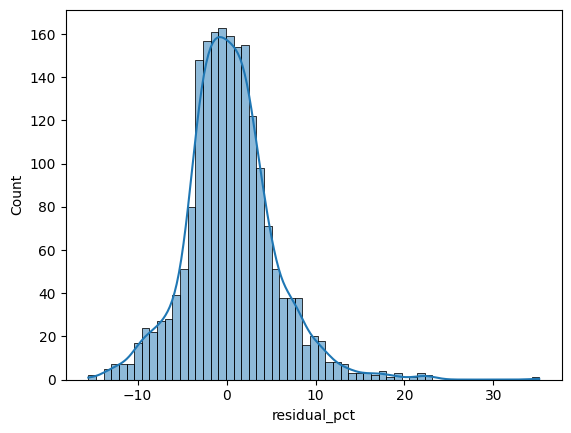

In [224]:
# histogram for residual_pct

sns.histplot(result_df['residual_pct'],kde=True)

In [225]:
# As per the business residual_pct can't be more then 10%
error_threshold = 10
error_df = result_df[result_df['residual_pct_abs']>=error_threshold]
error_df.shape

(106, 5)

In [226]:
result_df.shape

(1972, 5)

In [227]:
# total extream error which is more then 10%

extream_error_pct = error_df.shape[0]*100/result_df.shape[0]
extream_error_pct

5.37525354969574

## Notes -
- As we can see the total extream error percentage `(10%)` out of all the error dateset it's only `5.37%`.

In [228]:
result_df[np.abs(result_df['residual_pct_abs']>15)].sort_values('residual_pct_abs',ascending=False)

,actual,predict,residuals,residual_pct,residual_pct_abs
3994,3582,4841.240234,1259.240234,35.154669,35.154669
1518,4332,5331.723145,999.723145,23.077635,23.077635
7903,4315,5300.143555,985.143555,22.830673,22.830673
1170,4777,5836.363281,1059.363281,22.176330,22.176330
9048,4729,5777.178711,1048.178711,22.164912,22.164912
5649,4736,5777.178711,1041.178711,21.984348,21.984348
3962,4403,5331.723145,928.723145,21.092963,21.092963
596,4803,5745.599121,942.599121,19.625216,19.625216
8479,4457,5300.143555,843.143555,18.917289,18.917289
8356,4911,5836.363281,925.363281,18.842665,18.842665


In [229]:
# Total error for original dataset

x_test.index

Index([8496,  507, 5147,  887, 8848, 5638, 8963, 5231, 1095, 8685,
       ...
       5875, 9128, 4118,  824, 8031, 7231, 6771, 2308, 1915, 4656],
      dtype='int64', length=1972)

In [230]:
error_df.index

Index([ 887, 8963, 1918, 7772, 6559,   40, 9814, 2184,   82, 3128,
       ...
       7650, 1144, 5649, 7778, 6978, 7706, 2553, 6358, 6367, 4118],
      dtype='int64', length=106)

In [231]:
extream_error_df = x_test.loc[error_df.index]
extream_error_df

,age,number_of_dependants,income_lakhs,total_risk_score,life_style_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed,income_level,insurance_plan
887,-0.984917,-1.277463,-0.253148,0.000000,0.625,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
8963,-1.199577,0.718611,1.973811,0.357143,0.625,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.0
1918,-0.913363,-1.277463,0.459479,0.000000,0.000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,1.0
7772,-0.913363,-0.612105,-0.965775,0.000000,0.250,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.666667,0.0
6559,-1.271131,0.053253,0.103166,0.000000,0.500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7706,-1.414238,-0.612105,-0.832157,0.000000,0.125,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.666667,0.0
2553,-1.056470,-1.277463,0.637636,0.000000,0.625,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0
6358,-1.199577,-0.612105,-0.965775,0.000000,0.000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0
6367,-1.128024,0.053253,-0.164069,0.000000,0.250,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


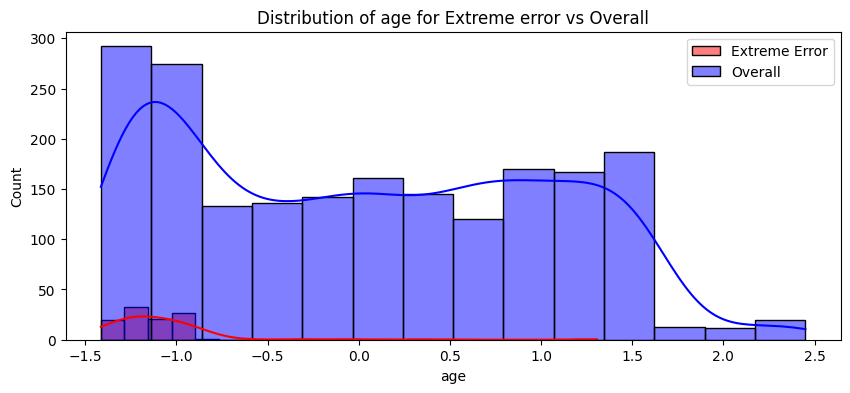

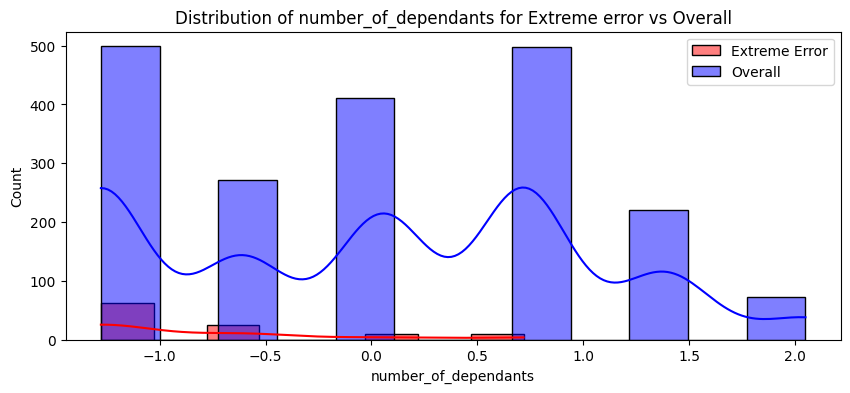

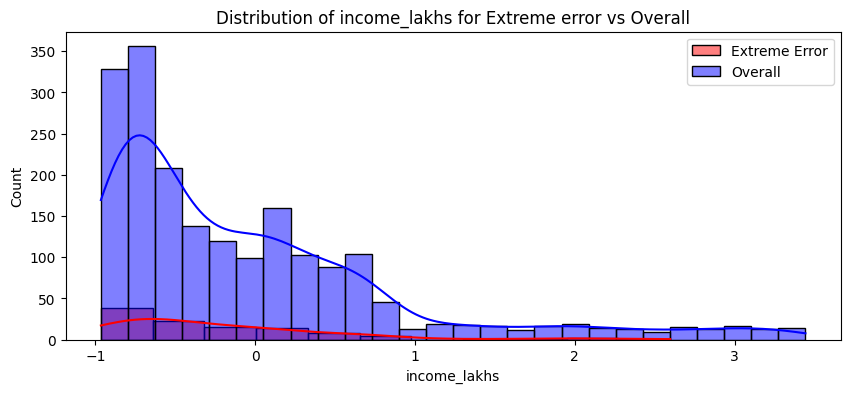

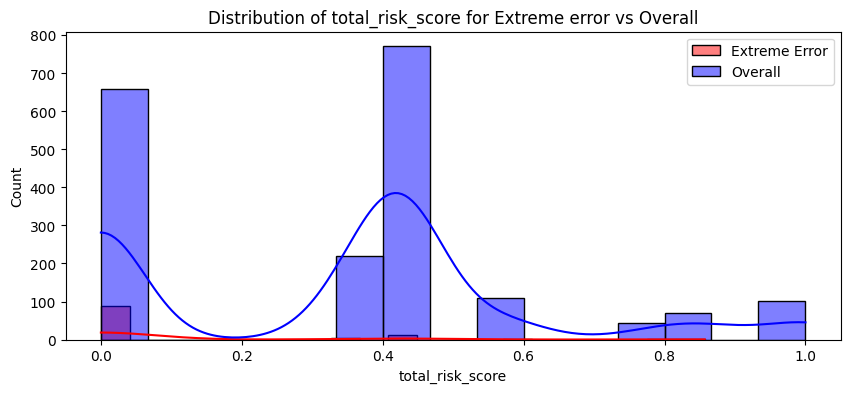

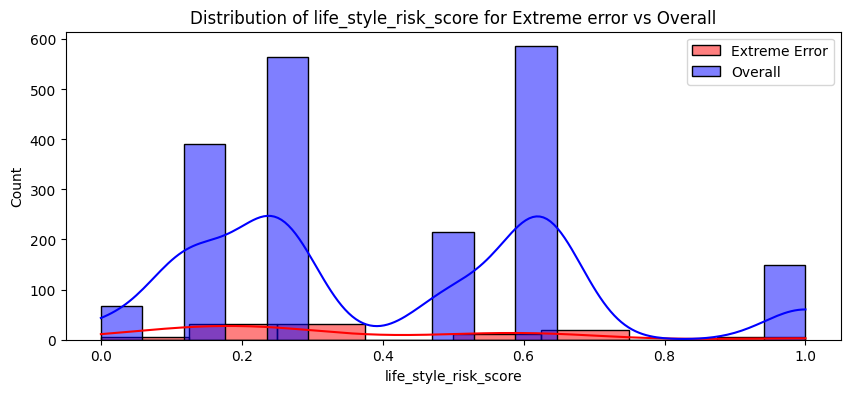

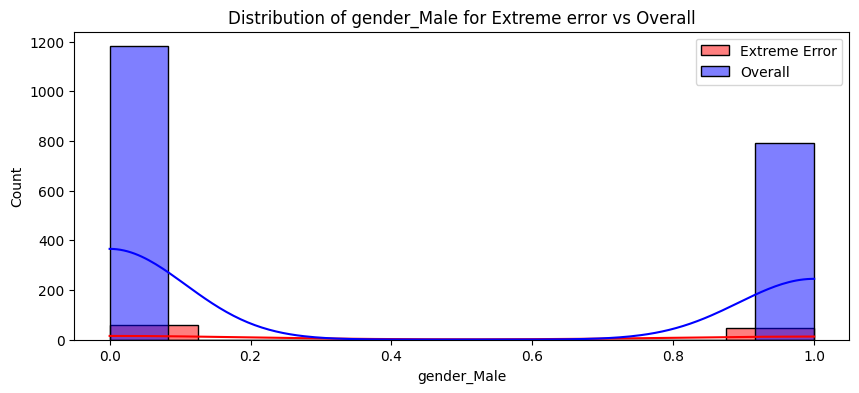

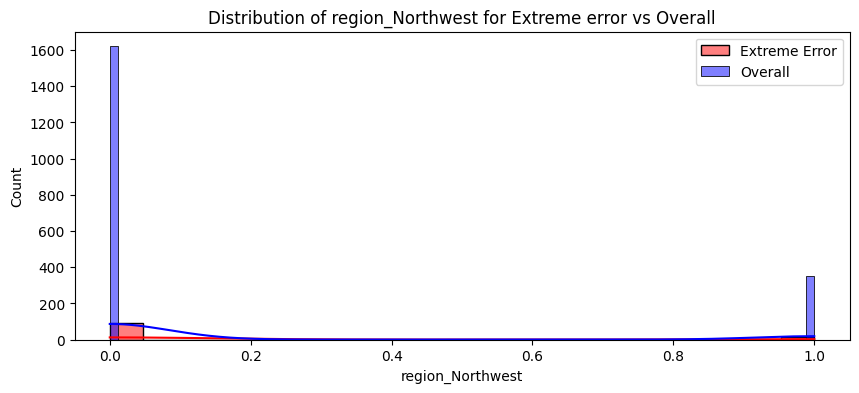

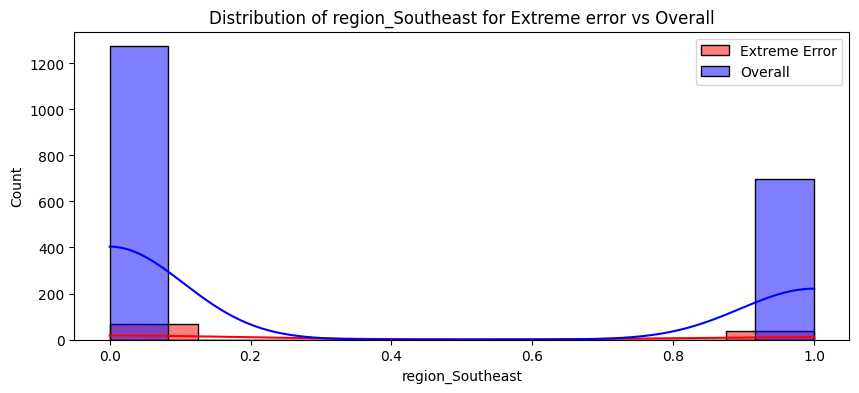

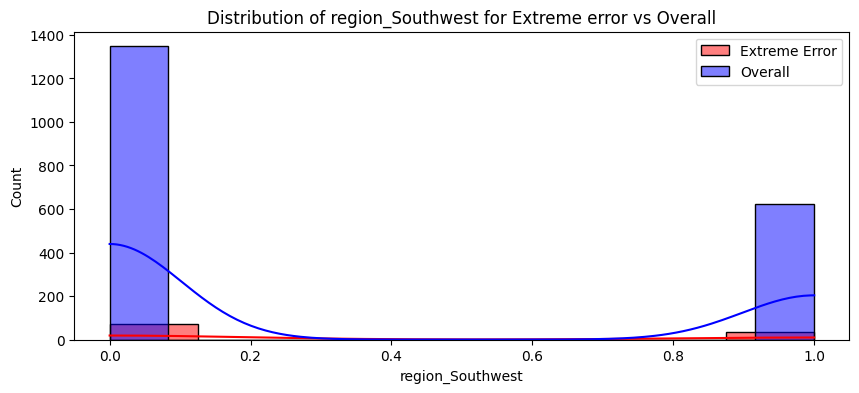

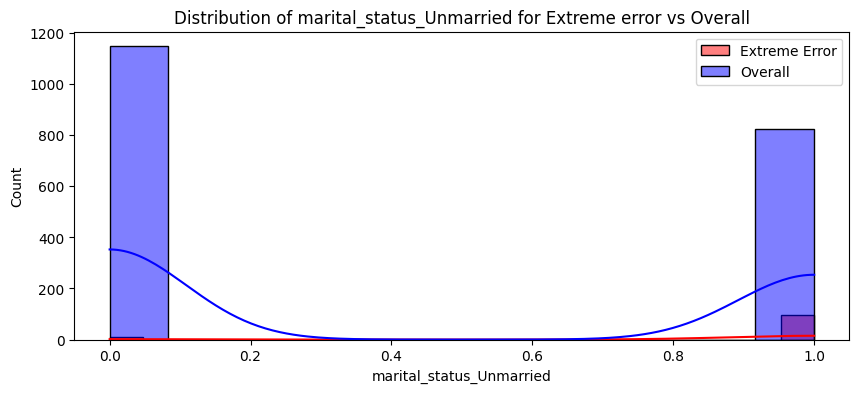

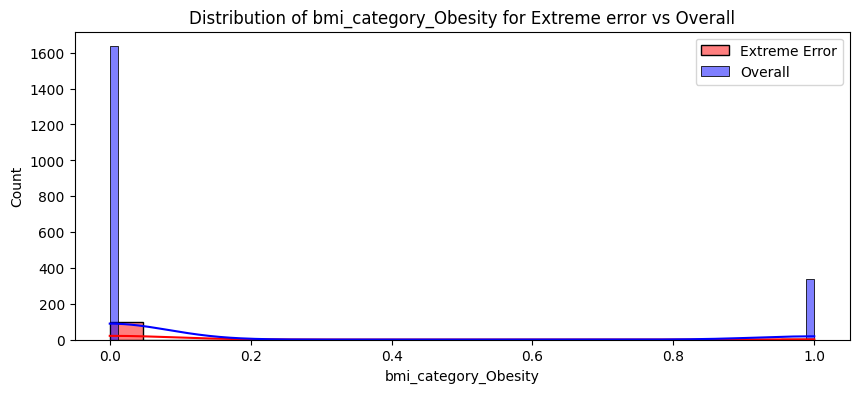

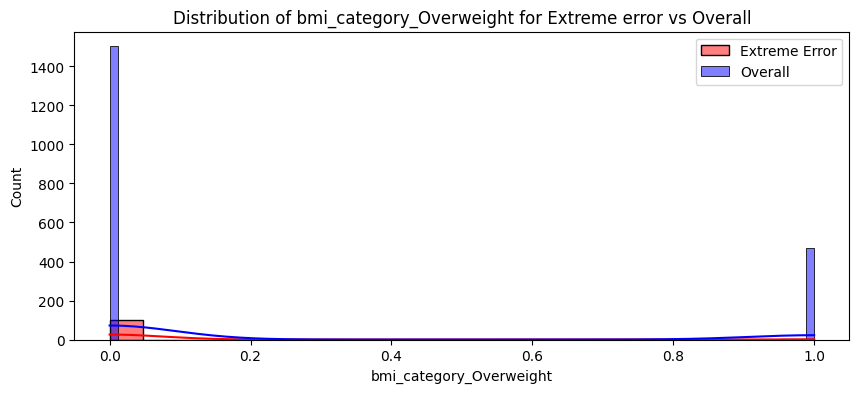

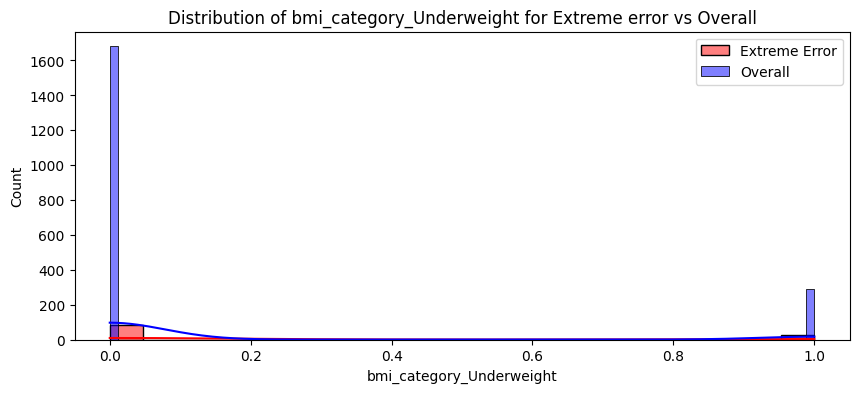

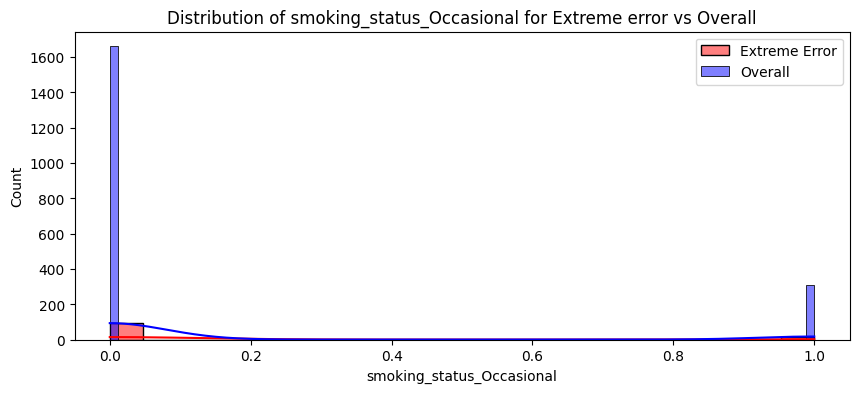

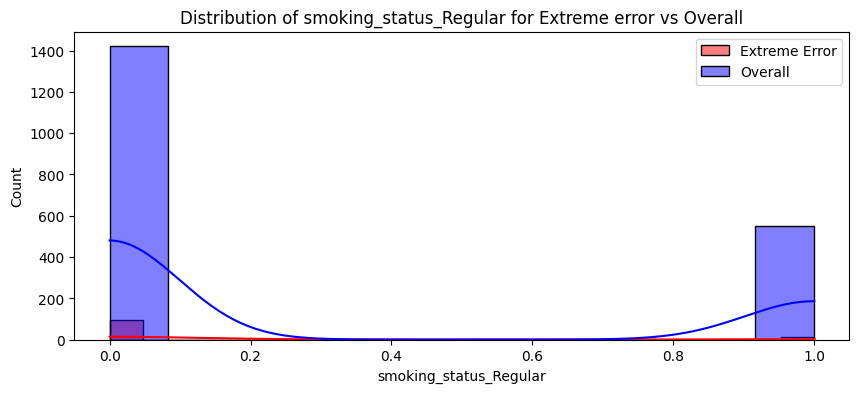

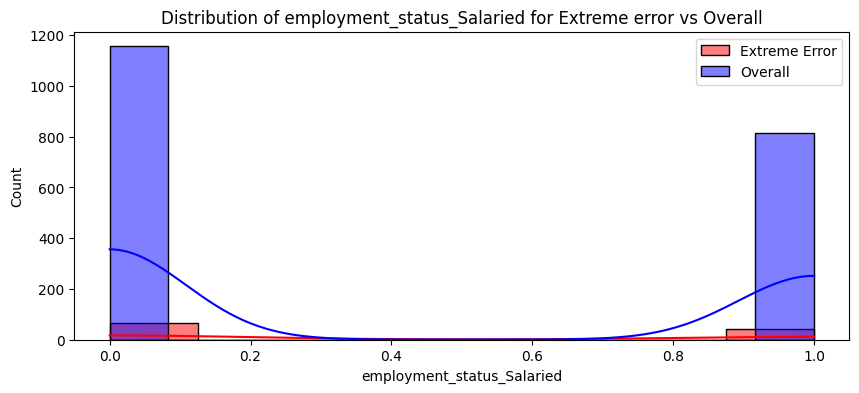

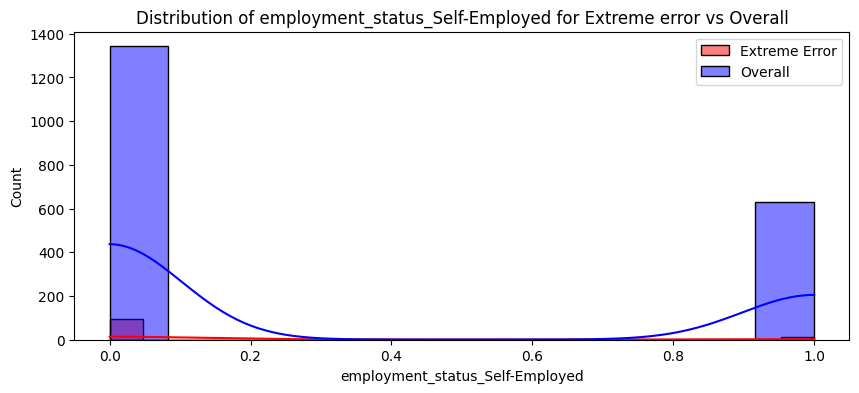

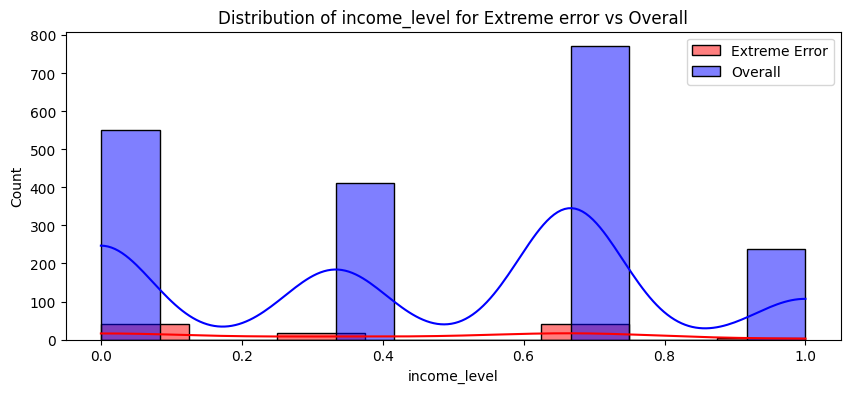

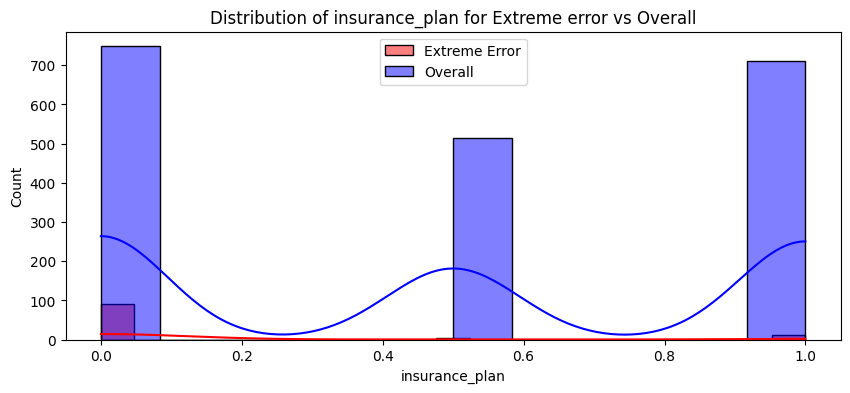

In [232]:
for x in x_test.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(extream_error_df[x],color='red',label='Extreme Error',kde=True)
    sns.histplot(x_test[x],color='blue',label='Overall',alpha=0.5,kde=True)
    plt.legend()
    plt.title(f'Distribution of {x} for Extreme error vs Overall')
    plt.show()